# Определение возраста покупателей

## Исследовательский анализ данных

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. Добейтесь значения MAE на тестовой выборке не больше 8.

**1.1 Загрузка библиотек и глобальных переменных.**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


**1.2 Пользовательские функции.**

In [2]:
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    print ('\033[1m' + 'Размер выборки:'+ '\033[0m')
    print(data_df.shape)
    print(data_df.describe())
               
    ## Посмотрим на сами данные
    
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())

**1.3 Загрузим данные.**

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


**1.4 Первичный осмотр данных.**

In [4]:
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
Размер выборки:
(7591, 2)
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

Первые пять строк датасета


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


**Построим график распределения возраста.**

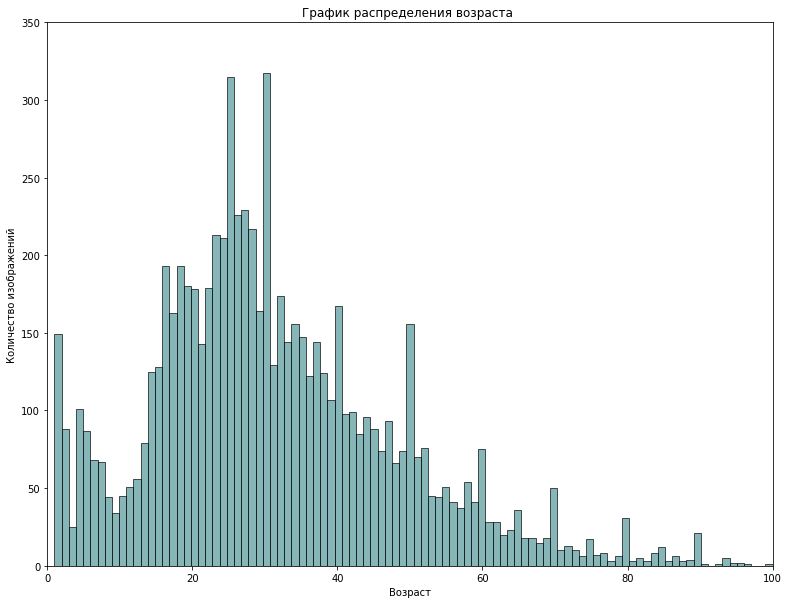

In [11]:
plt.figure(figsize=[13, 10])

sns.histplot(df['real_age'], bins=100, color='cadetblue')

plt.xlim([0, 100])
plt.ylim([0, 350])

plt.xlabel('Возраст')
plt.ylabel('Количество изображений')

plt.title('График распределения возраста ')
plt.show()

**Выведем 15 изображений.**

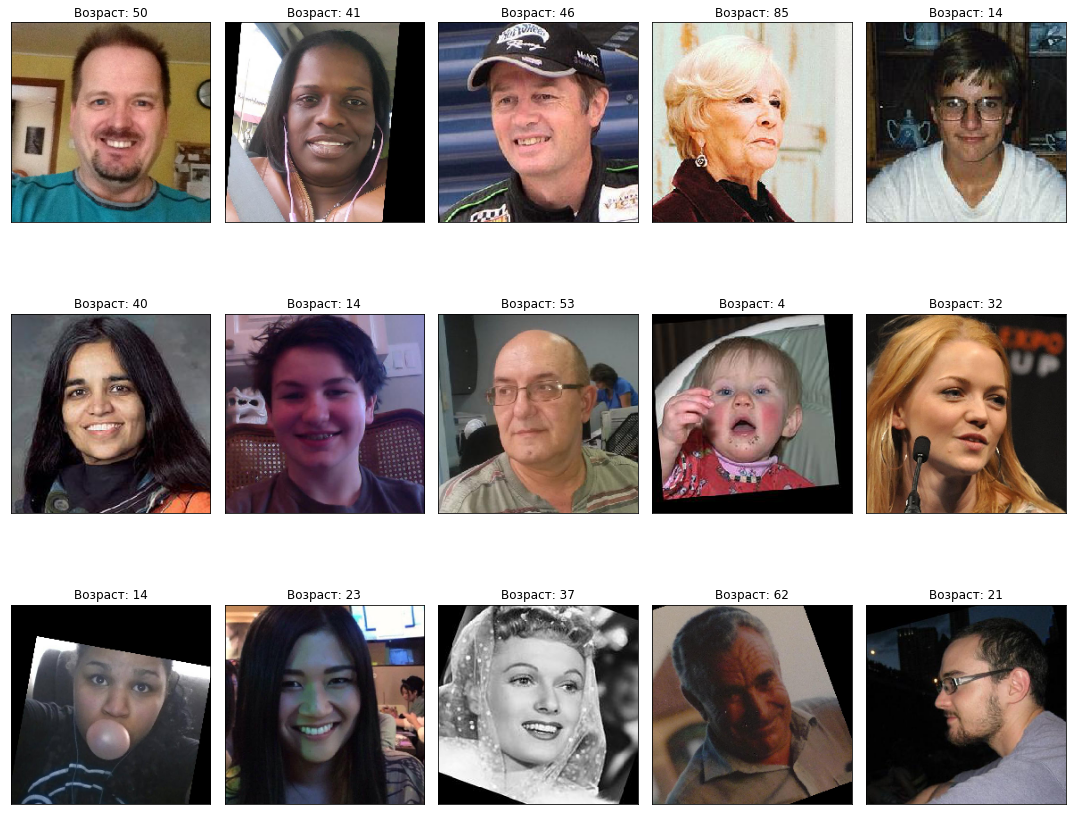

In [6]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(f'Возраст: {target[i]}')

**Вывод:**
- в таблице 7591 строка и 2 столбца;
- столбец 'file_name' с названием изображения;
- столбец 'real_age' с возрастом изображенного человека;
- пропущенных значений нет;
- большинство изображений - лица крупным планом;
- встречаются цветные и черно-белые изображения;
- на некоторых изображениях не видно лиц, оно слишком сильно повернуто или закрыто предметом;
- исходя из графика - возрастные пики приходятся на юбилейные года, что может быть связано с округлением возраста при разметке данных;
- данные размечены верно;
- необходимо использовать методы аугментации для улучшения качества, т.к.данных не очень много.

## Обучение модели

**2.1 Обучим нейронную сеть и рассчитаем её качество:**

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                           directory=path + 'final_files',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode="raw",
                                                           subset='training',
                                                           seed=12345)
    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe = df,
                                                         directory = path + 'final_files',
                                                         x_col = 'file_name',
                                                         y_col = 'real_age',
                                                         target_size = (224, 224),
                                                         batch_size = 32,
                                                         class_mode = 'raw',                                                
                                                         subset='validation',     
                                                         seed=12345)
    return test_datagen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))   
 
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model
            
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch=len(train_data)
   
    if validation_steps is None:
        validation_steps=len(test_data)
         
    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              epochs=epochs)
 
    return model

Train for 178 steps, validate for 60 steps \
Epoch 1/15 \
178/178 - 106s - loss: 252.3134 - mae: 11.4318 - val_loss: 830.4058 - val_mae: 23.9219\
Epoch 2/15\
178/178 - 99s - loss: 94.5903 - mae: 7.2911 - val_loss: 808.4086 - val_mae: 23.4875\
Epoch 3/15\
178/178 - 99s - loss: 69.6292 - mae: 6.3040 - val_loss: 307.4831 - val_mae: 13.0702\
Epoch 4/15\
178/178 - 100s - loss: 55.8059 - mae: 5.7338 - val_loss: 120.9507 - val_mae: 8.3475\
Epoch 5/15\
178/178 - 99s - loss: 50.2572 - mae: 5.4252 - val_loss: 126.3736 - val_mae: 8.6582\
Epoch 6/15\
178/178 - 100s - loss: 42.0107 - mae: 4.9837 - val_loss: 86.6429 - val_mae: 7.0481\
Epoch 7/15\
178/178 - 99s - loss: 37.2439 - mae: 4.6872 - val_loss: 72.9423 - val_mae: 6.3540\
Epoch 8/15\
178/178 - 99s - loss: 33.2431 - mae: 4.4435 - val_loss: 70.8946 - val_mae: 6.2417\
Epoch 9/15\
178/178 - 100s - loss: 31.6792 - mae: 4.3332 - val_loss: 90.9267 - val_mae: 7.2055\
Epoch 10/15\
178/178 - 101s - loss: 26.4384 - mae: 3.9556 - val_loss: 67.4518 - val_mae: 6.0441\
Epoch 11/15\
178/178 - 98s - loss: 23.3218 - mae: 3.7738 - val_loss: 69.6763 - val_mae: 6.1989\
Epoch 12/15\
178/178 - 99s - loss: 22.4402 - mae: 3.6723 - val_loss: 83.8636 - val_mae: 6.6706\
Epoch 13/15\
178/178 - 99s - loss: 19.6784 - mae: 3.4333 - val_loss: 80.2525 - val_mae: 6.5883\
Epoch 14/15\
178/178 - 99s - loss: 17.3898 - mae: 3.2366 - val_loss: 90.5545 - val_mae: 6.9373\
Epoch 15/15\
178/178 - 101s - loss: 16.9082 - mae: 3.1860 - val_loss: 61.9312 - val_mae: 5.9048\

60/60 - 11s - loss: 61.9312 - mae: 5.9048\
**Test MAE: 5.9048**


## Анализ обученной модели

Мы достигли значения **МАЕ на тестовой выборке:
5.9048** - что соответствует условию задачи.

Создана нейронная сеть с архитектурой ResNet50.\
Модель обучена достаточно быстро, за 15 эпох и позволяет определять возраст покупателей с достаточно высокой точностью.

## **Общий вывод:**

**Произведён анализ данных:**
- в таблице 7591 строка и 2 столбца;
- столбец 'file_name' с названием изображения;
- столбец 'real_age' с возрастом изображенного человека;
- пропущенных значений нет;
- большинство изображений - лица крупным планом;
- встречаются цветные и черно-белые изображения;
- на некоторых изображениях не видно лиц, оно слишком сильно повернуто или закрыто предметом;
- исходя из графика - возрастные пики приходятся на юбилейные года, что может быть связано с округлением возраста при разметке данных;
- данные размечены верно;
- необходимо использовать методы аугментации для улучшения качества, т.к.данных не очень много.

**Обучена и проанализирована модель:**
- создана нейронная сеть с архитектурой ResNet50;
- модель обучена достаточно быстро, за 15 эпох;
- модель позволяет определять возраст покупателей с достаточно высокой точностью.
- значение **МАЕ на тестовой выборке: 5.9048**.

**Ответим на главные вопросы:**
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы - **наша модель может.**
- Контролировать добросовестность кассиров при продаже алкоголя - **наша модель не может**,
т.к. ошибка для этого слишком велика и погрешность в 5-6 лет имеет большое значение при продаже товаров 18+.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы